# 6-13. 프로젝트 : This is your playground! Leaderboard를 정복해 주세요!

## ✓ 사전 - 기본 프로젝트 처리

### 1. 필요 package 설치

In [1]:
conda install -c conda-forge xgboost=1.3.3

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.1
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - xgboost=1.3.3


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _py-xgboost-mutex-2.0      |            cpu_0           8 KB  conda-forge
    ca-certificates-2021.5.30  |       ha878542_0         136 KB  conda-forge
    certifi-2021.5.30          |   py37h89c1867_0         141 KB  conda-forge
    joblib-1.0.1               |     pyhd8ed1ab_0         206 KB  conda-forge
    libxgboost-1.3.3           |       h9c3ff4c_2 

In [2]:
conda install -c conda-forge lightgbm=3.1.1 

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.1
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - lightgbm=3.1.1


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    lightgbm-3.1.1             |   py37hcd2ae1e_0         1.6 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         1.6 MB

The following NEW packages will be INSTALLED:

  lightgbm           conda-forge/linux-64::lightgbm-3.1.1-py37hcd2ae1e_0



lightgbm-3.1.1       | 1.6 MB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated 

In [3]:
conda install -c conda-forge missingno=0.4.2

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.1
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - missingno=0.4.2


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    missingno-0.4.2            |             py_1          12 KB  conda-forge
    pandas-1.3.1               |   py37h219a48f_0        12.7 MB  conda-forge
    patsy-0.5.1                |             py_0         187 KB  conda-forge
    seaborn-0.11.1             |       hd8ed1ab_1           4 KB  conda-forge
    seaborn-base-0.11.1        |     pyhd8ed1ab_1         217 KB  conda-forge
    statsmodels-0.12.2         |   py37h902c9e0_0        11.3 MB  conda-forge
    ------------------------------------------------------------
                    

### 2. package import

In [4]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns


### 3. 데이터 로드

In [6]:
# train_data_path = join('../input', 'train.csv')
# sub_data_path = join('../input', 'test.csv')

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(sub_data_path)

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


### 4. 데이터 살펴보기

pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [7]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [15]:
# 각종 함수 참조 : 출처 : https://www.kaggle.com/rangmar/25th-solution-xgb-lightgbm-ensemble

def haversine_array(lat2, lng2):
    lat1, lng1 = 47.63, -122.22
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def rmse_exp(predictions, dmat):
    labels = dmat.get_label()
    diffs = np.expm1(predictions) - np.expm1(labels)
    squared_diffs = np.square(diffs)
    avg = np.mean(squared_diffs)
    return ('rmse_exp', np.sqrt(avg))

def print_best_params(model, params):
    grid_model = GridSearchCV(
        model, 
        param_grid = params,
        scoring='neg_mean_squared_error',
        cv=5,
        n_jobs=-1
    )

    grid_model.fit(X_train, y_train)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print(
        '{0} 5 CV 시 최적 평균 RMSE 값 {1}, 최적 alpha:{2}'.format(model.__class__.__name__, np.round(rmse, 6), grid_model.best_params_))
    return grid_model.best_estimator_

def zipcode_groupby(train, test, group_col, colname, agg_method) :
    new_colname = 'price_per'+'_'+colname
    #new_colname2 = colname+'mean'
    
    train[new_colname] = train['price']/train[colname]
    price_per_temp = train.groupby([group_col])[new_colname].agg(agg_method)
    price_per_temp.columns = ['{}_{}'.format(new_colname, m) for m in agg_method]
    price_per_temp = price_per_temp.reset_index()
    #price_per_temp.rename(columns={'mean':new_colname2}, inplace=True)
    train = pd.merge(train, price_per_temp, how='left', on=group_col)
    test = pd.merge(test, price_per_temp, how='left', on=group_col)
    
    del train[new_colname]
    
    return train, test

def groupby_helper(df, group_col, target_col, agg_method, prefix_param=None):
    try:
        prefix = get_prefix(group_col, target_col, prefix_param)
        print(group_col, target_col, agg_method)
        group_df = df.groupby(group_col)[target_col].agg(agg_method)
        group_df.columns = ['{}_{}'.format(prefix, m) for m in agg_method]
    except BaseException as e:
        print(e)
    return group_df.reset_index()

def get_prefix(group_col, target_col, prefix=None):
    if isinstance(group_col, list) is True:
        g = '_'.join(group_col)
    else:
        g = group_col
    if isinstance(target_col, list) is True:
        t = '_'.join(target_col)
    else:
        t = target_col
    if prefix is not None:
        return prefix + '_' + g + '_' + t
    return g + '_' + t

def category_feature_distribution(train, col, target='price'):
    fig, ax = plt.subplots(1, 2, figsize=(16,4))
    
    for c in sorted(train[col].unique()):
        sns.distplot(train.loc[train[col]==c, target], ax=ax[0])
    ax[0].legend(sorted(train[col].unique()))
    ax[0].set_title(f'{col} {target} distribution')

    sns.boxplot(x=col, y=target, data=train, ax=ax[1])
    ax[1].set_title(f'{col} vs {target}')
    
    plt.show()
    
def haversine_array_new(lat1_raw, lng1_raw, lat2, lng2):
    lat1, lng1 = lat1_raw, lng1_raw
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def haversine_array_low(lat2, lng2):
    lat1, lng1 = 47.382, -122.247
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

데이터 

참조 : https://www.kaggle.com/tmheo74/geo-data-eda-and-feature-engineering#Zipcode-Feature-Engineering

LightGBM 5-Fold Out Of Fold Prediction을 Baseline model로 사용하겠습니다.
기본 데이터의 Baseline model CV 스코어는 아래와 같습니다. Categorical 데이터는 One Hot Encoding으로 처리하겠습니다.

In [14]:
data['zipcode-3'] = 'z_' + data['zipcode'].str[2:3]
data['zipcode-4'] = 'z_' + data['zipcode'].str[3:4]
data['zipcode-5'] = 'z_' + data['zipcode'].str[4:5]
data['zipcode-34'] = 'z_' + data['zipcode'].str[2:4]
data['zipcode-45'] = 'z_' + data['zipcode'].str[3:5]
data['zipcode-35'] = 'z_' + data['zipcode'].str[2:3] + data['zipcode'].str[4:5]

print(data.shape)
data.head()

AttributeError: Can only use .str accessor with string values!

In [8]:
y = data['price']

del data['price']

In [9]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

In [10]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [ ]:
X_train, X_test, y_train = train_test_split(data)
print(X_train.shape, X_test.shape)

lgb_param = {
    'objective': 'regression',
    'learning_rate': 0.05,
    'num_leaves': 15,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'feature_fraction': 0.7,
    'seed': RANDOM_SEED,
    'metric': ['rmse'],
}

oof, pred, cv_score, fi_df = get_oof_lgb(X_train, y_train, X_test, lgb_param)

### 5. 간단한 전처리

<AxesSubplot:>

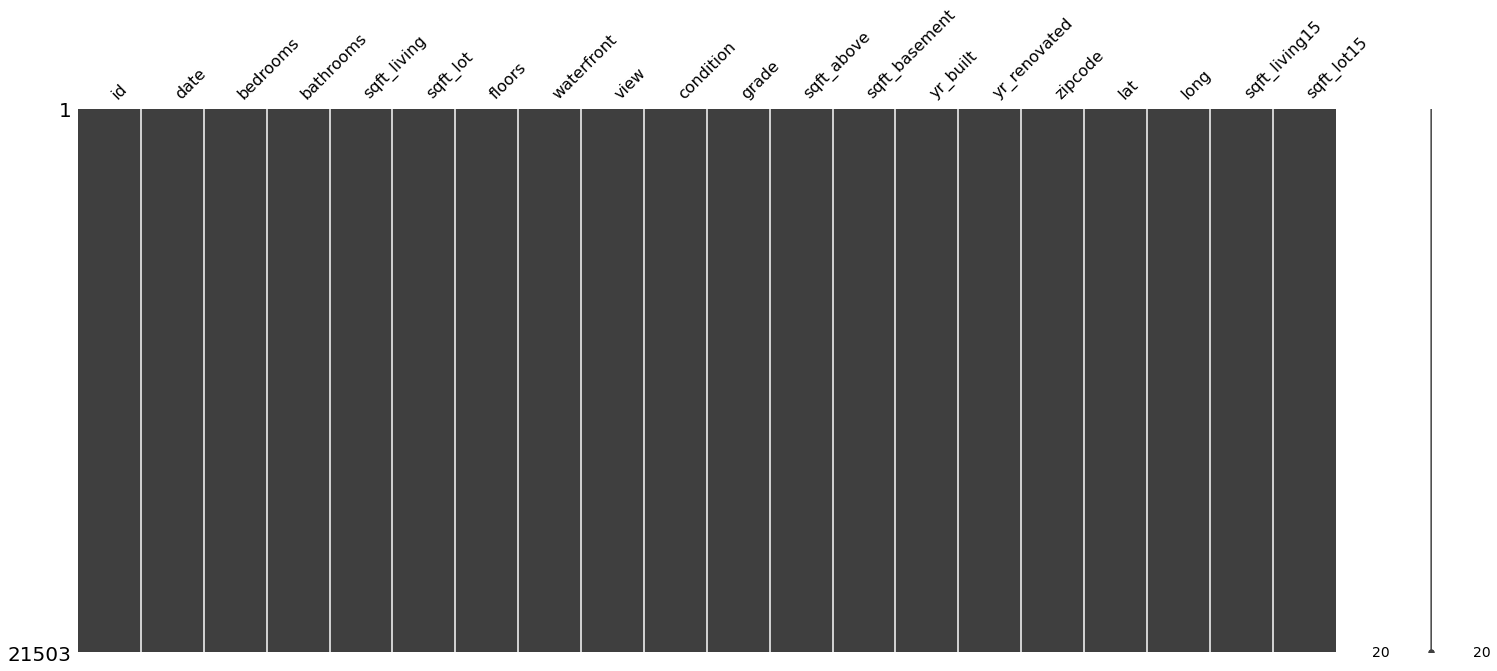

In [11]:
# 결측치 확인
msno.matrix(data)

In [12]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


#### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [13]:
sub_id = data['id'][train_len:]
del data['id']
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str)

#### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

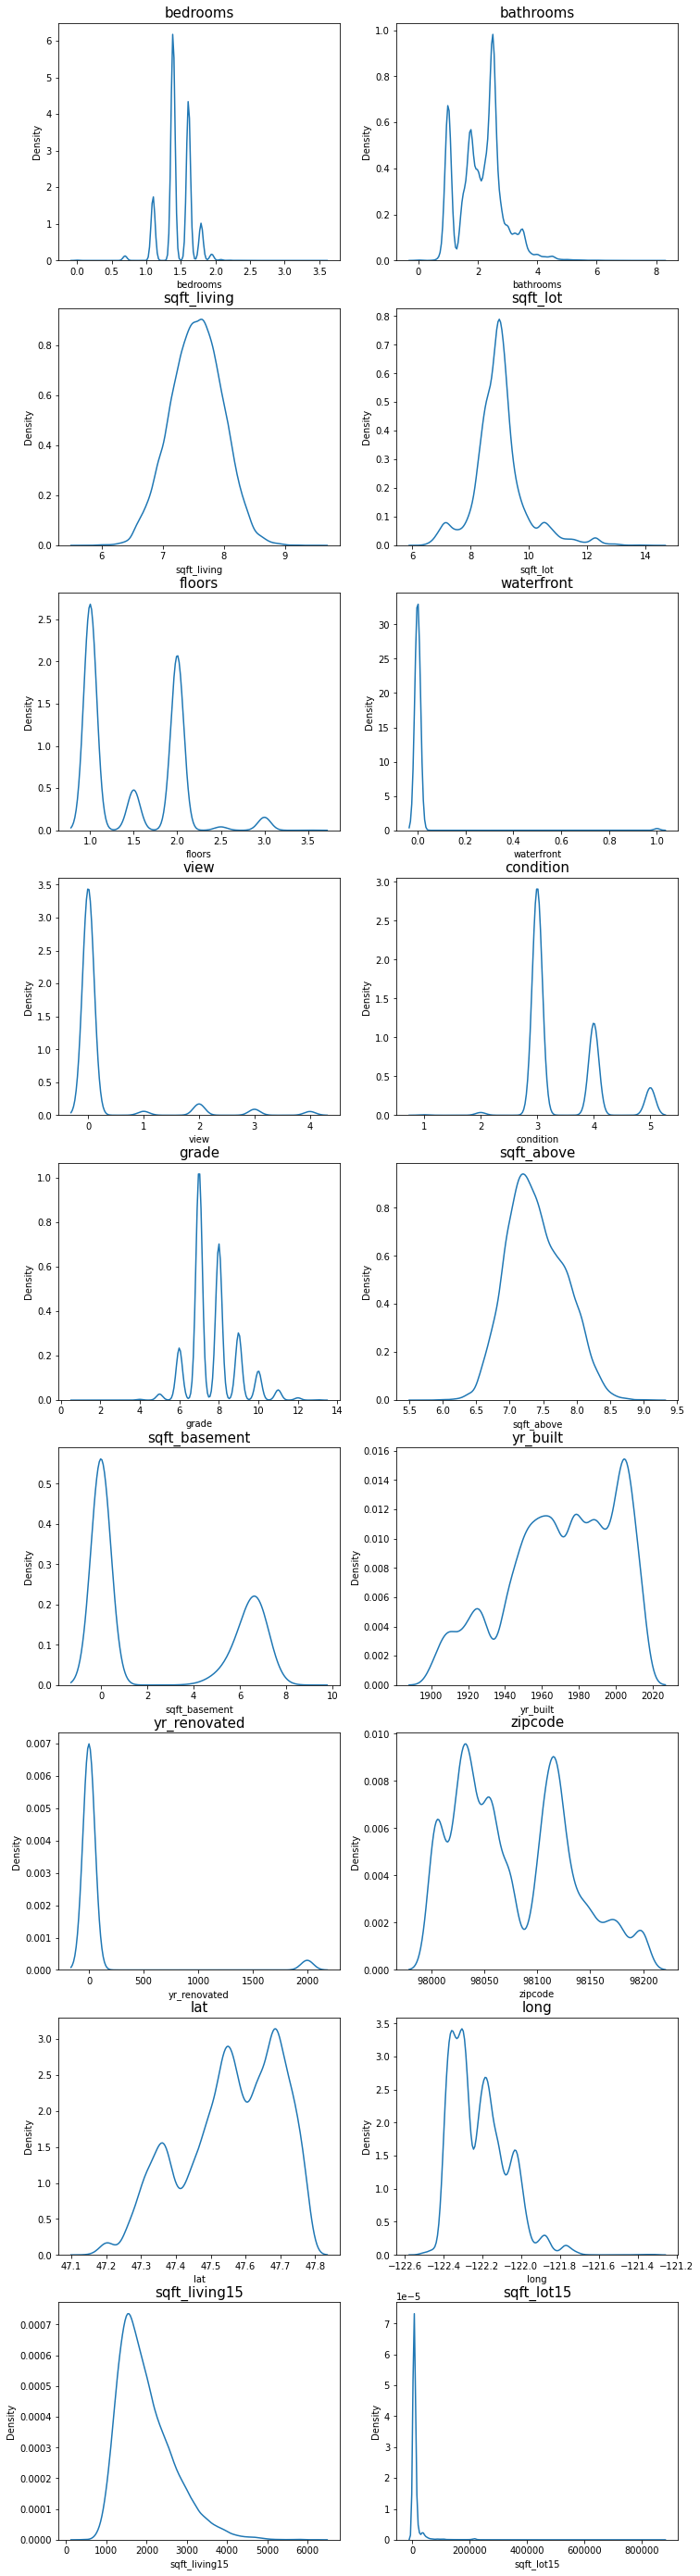

In [23]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

In [24]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

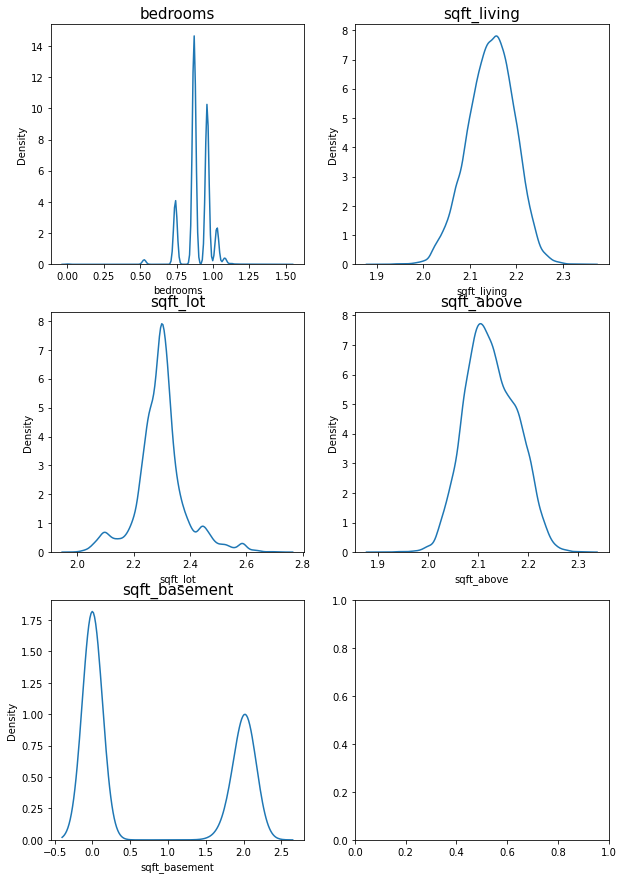

In [25]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1



In [26]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

In [30]:
print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


#### 6. 모델링
**Average Blending**
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [31]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'}, {'model':lightgbm, 'name':'LightGBM'}]

#### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [32]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, shuffle=True, random_state=2019).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), kf=kfold))


In [33]:
get_cv_score(models)

Model GradientBoosting CV score : 0.8597
Model XGBoost CV score : 0.8860
Model LightGBM CV score : 0.8819


#### 7. Make Submission


In [34]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)


In [35]:
y_pred = AveragingBlending(models, x, y, sub)

In [36]:
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})

In [37]:
sub.to_csv('submission.csv', index=False)

#### 8. 함수정리


In [39]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [1]:
# 코드 작성
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

#### 기본 모델 수행

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [51]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

# 데이터 로딩
train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)


# 데이터 전처리
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

y = train['price']
del train['price']
del train['id']

y = np.log1p(y)

# 파라미터 설정
random_state=2020  # 이번엔 세팅값 고정

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

# 모델 생성 및 수행
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=10)



Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [52]:
# 저장
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

ValueError: Number of features of the model must match the input. Model n_features_ is 19 and input n_features is 20 

참고 캐글 : https://www.kaggle.com/rangmar/25th-solution-xgb-lightgbm-ensemble